In [53]:
'''
**********************************************
# TITLE: ASSIGNMENT 2: IMAGE MOSAIC CREATION # 
# #Panorama #Stitching #Blending #Homography #
# COURSE: COL780 - COMPUTER VISION           #
# INSTRUCTOR: PROF. CHETAN ARORA             #
# AUTHOR: AMAN BHARDWAJ                      #
# DATE: 20 NOV 2020                          #
**********************************************
'''
''' IMPORT PACKAGES '''
import os
import cv2 as cv
import json
from glob import glob
import numpy as np
import argparse
import matplotlib.pyplot as plt
from time import time
import networkx as nx
import maxflow as mf
#%matplotlib inline

Reading Image ---> ./val_set/1/1a.png
Reading Image ---> ./val_set/1/1b.png
(562, 1000, 3) (562, 1000, 3) <class 'numpy.ndarray'> <class 'numpy.ndarray'>


%%%% IMAGE: KNN_MATCHES1, SHAPE: (962, 3000, 3) %%%%


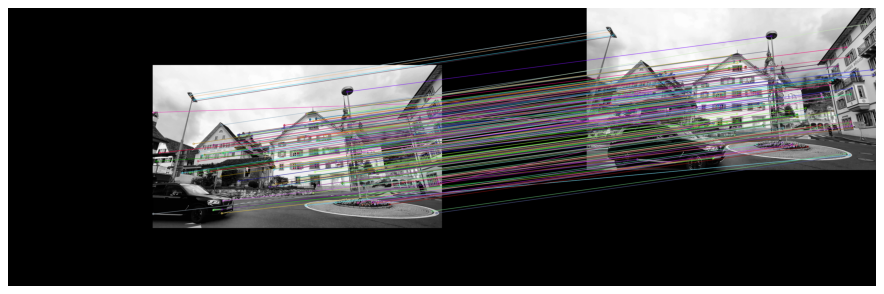

# Good Matches =257, # Minimum Points =40


%%%% IMAGE: MOSAIC1, SHAPE: (962, 2000, 3) %%%%


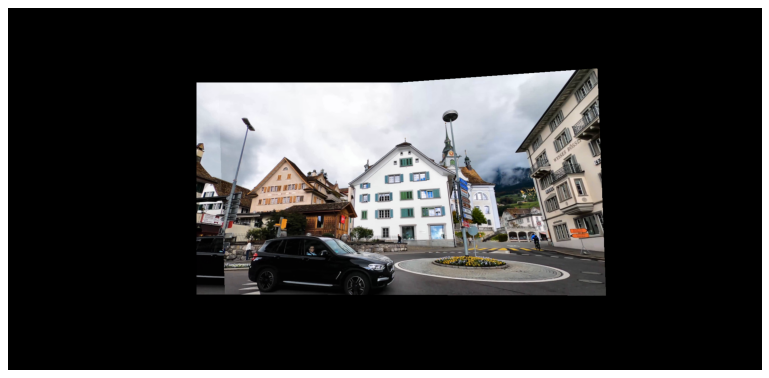



%%%% IMAGE: M1, SHAPE: (962, 2000) %%%%


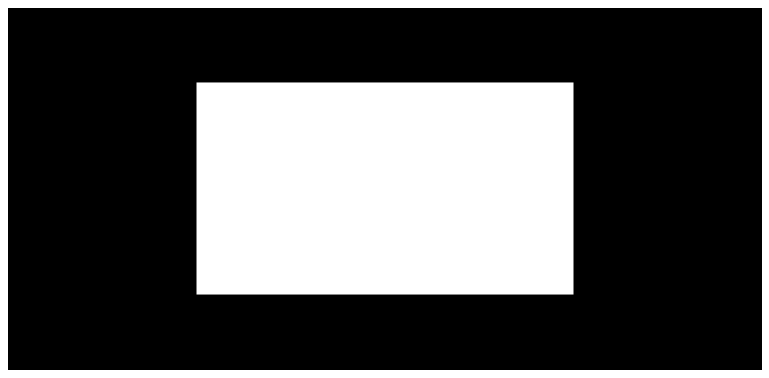



%%%% IMAGE: M2, SHAPE: (962, 2000) %%%%


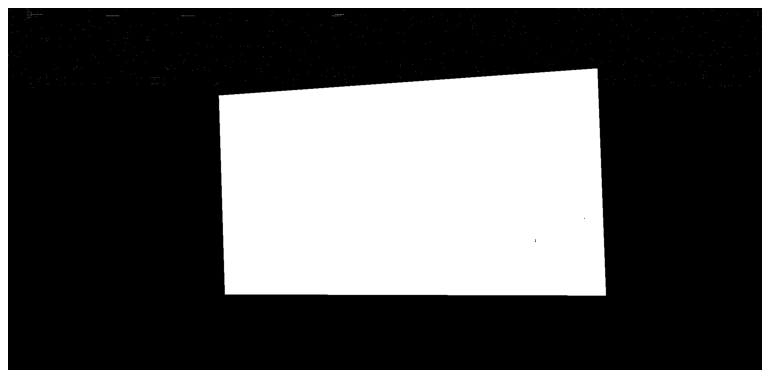

(962, 2000, 3) (962, 2000, 3)


%%%% IMAGE: ENERGY MAP1, SHAPE: (962, 2000) %%%%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


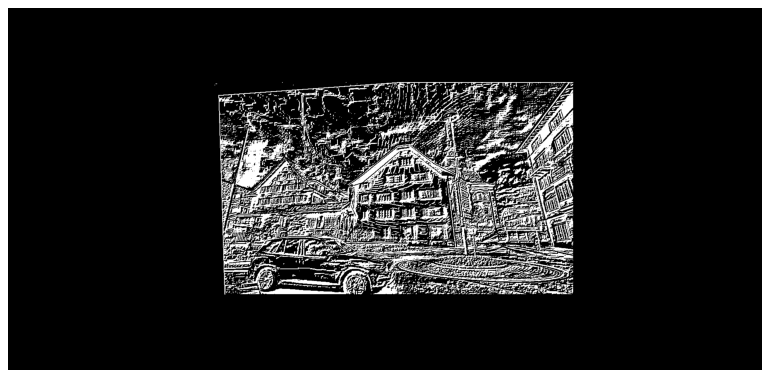



%%%% IMAGE: ENERGY MAP2, SHAPE: (962, 2000) %%%%


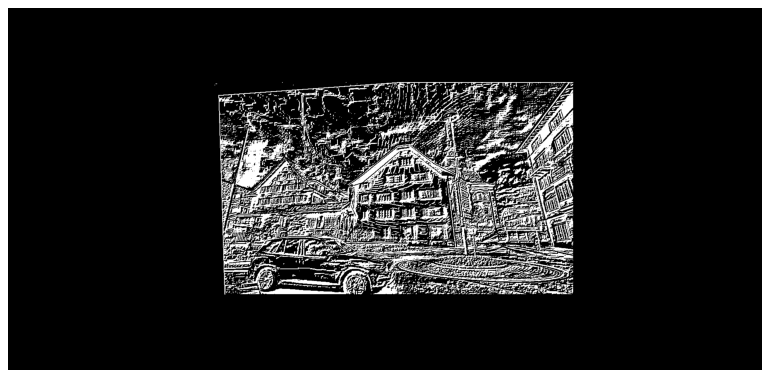

maxflow: 0.0


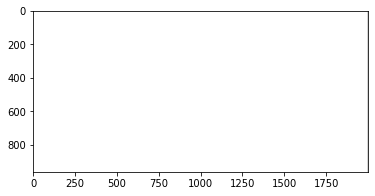

In [58]:
""" HELPER FUNCTIONS """
def save_mosaic(fileName, mos):
    '''Save Mosaic in the same folder as createmosaic.py file.'''
    print("Saving --->", fileName)
    cv.imwrite(fileName, mos)
    return

def show_image(img, title='Default', save=False):
    '''Display and save image'''
    if img is None:
        print('Could not find image to show.')
    else:        
        print("\n\n%%%% IMAGE: {}, SHAPE: {} %%%%".format(title, img.shape))
        fig = plt.figure(num=0, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
        plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()
        if save:
            fig.savefig("plots/"+title+".png", dpi=300, format="png")       
    return

def read_image(fileName):
    '''Read image from the specified path.'''
    print("Reading Image --->", fileName)
    img = cv.imread(fileName)
    return img

def hconcat_images(image_list):
    '''Concat images horizontally'''
    return cv.hconcat(image_list)

class ImgProcessing:
    '''
    class: ImgProcessing
    contains functions to prepare the images for mosaicing
    '''
    def image_resize(self, image, inter = cv.INTER_AREA):
        dim = None
        (h, w) = image.shape[:2]
        height = width = None
        if h > w:
            height = 1000
        else:
            width = 1000

        if width is None:
            r = height / float(h)
            dim = (int(w * r), height)        
        else:
            r = width / float(w)
            dim = (width, int(h * r))

        resized = cv.resize(image, dim, interpolation = inter)
        return resized

    def brightness_equalize(self, img):
        img_yuv = cv.cvtColor(img, cv.COLOR_BGR2YUV)
        img_yuv[:,:,0] = cv.equalizeHist(img_yuv[:,:,0])
        img_output = cv.cvtColor(img_yuv, cv.COLOR_YUV2BGR)
        return img_output

    def apply_clahe(self, img, limit=1, grid=(8,8)):
        '''
        CLAHE:
        Histogram Equalization and Contrast enhancement
        '''    
        img_yuv = cv.cvtColor(img, cv.COLOR_BGR2YUV)

        clahe = cv.createCLAHE(clipLimit=limit, tileGridSize=grid)
        img_yuv[:,:,0] = clahe.apply(img_yuv[:,:,0])    
        img_output = cv.cvtColor(img_yuv, cv.COLOR_YUV2BGR)

        return img_output


class RegisterImage:
    
    def cvt_gray(self, img):
        '''Convert BRG Image to Grayscale'''
        return cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    
    def orbs_magic(self, img, show=False):
        #init ORB
        orb = cv.SIFT_create(nfeatures = 500)
        #detect keypoints
        img = self.cvt_gray(img)
        keyPoints = orb.detect(img, None)
        #get descriptor
        keyPoints, imgDescriptors = orb.compute(img, keyPoints)

        if show:
            #draw detected keypoints on image and show
            img2 = img
            img2 = cv.drawKeypoints(img,keyPoints,img2,color=(0,255,0), flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
            show_image(img2, "ORB_DETECTOR")

        return keyPoints, imgDescriptors

    def flann_matcher(self, d1, d2, K=2):
        search_params = {'checks': 50} #default params
        index_params = {'algorithm': 1, 'table_number': 6, 'key_size': 12, 'multi_probe_level': 1, 'trees': 5} #algo = FLANN_INDEX_LSH
        #init flann
        flann = cv.FlannBasedMatcher(index_params, search_params)
        knn_matches = flann.knnMatch(d1, d2, k=K)
        #bf = cv.BFMatcher()
        #bf_matches = bf.knnMatch(d1,d2, k=2)
        return knn_matches

    def get_good_matches(self, matches, thresh=0.8):
        good_matches = []
        for m in matches:
            if m[0].distance < thresh * m[1].distance:
                good_matches.append(m[0])
        return good_matches   

    def draw_matches(self, img1, img2, k1, k2,  g_matches, draw=False):
        img1 = self.cvt_gray(img1)
        img2 = self.cvt_gray(img2)
        match_canvas = cv.drawMatches(img1, k1, img2, k2, g_matches, None, 
                                      flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        if draw:
            show_image(match_canvas, "KNN_MATCHES"+str(i), True)
        return

    def est_homography(self, k1, k2, confident_matches, min_matches=20):
        print("# Good Matches ={}, # Minimum Points ={}".format(len(confident_matches), min_matches))
        if len(confident_matches) >= min_matches:
            points_img1 = [k1[m.queryIdx].pt for m in confident_matches]
            points_img2 = [k2[m.trainIdx].pt for m in confident_matches]
            points_img1 = np.array(points_img1, dtype=np.float32).reshape(-1, 1, 2)
            points_img2 = np.array(points_img2, dtype=np.float32).reshape(-1, 1, 2)
            H, mask = cv.findHomography(points_img2, points_img1, cv.RANSAC, 5.0)
            inliers = list(mask.ravel())
        else:
            print("Number of Good Matches are less than Minimum Points set for Homography estimation.")
            H = inliers = None
        return H, inliers

class ImageBlending:
    def warp_image(self, i1, i2, H, show=False):
        h1, w1 = i1.shape[:2]
        h2, w2 = i2.shape[:2]    
        h = h1 + h2
        w = w1 + w2
        tpl = (w,h)
        gray = cv.cvtColor(i1, cv.COLOR_BGR2GRAY)
        thresh1 = cv.threshold(gray, 0, 255, cv.THRESH_BINARY)[1]
        i1_mask = thresh1
        gray = cv.cvtColor(i2, cv.COLOR_BGR2GRAY)
        thresh2 = cv.threshold(gray, 0, 255, cv.THRESH_BINARY)[1]
        
        mosaic = cv.warpPerspective(i2, H, (w1,h1), dst=i1.copy(), borderMode=cv.BORDER_TRANSPARENT)
        i2_mask = cv.warpPerspective(thresh2, H, (w1,h1), borderMode=cv.BORDER_TRANSPARENT)
        i2_mask = cv.threshold(i2_mask, 254, 255, cv.THRESH_BINARY)[1]
        #mosaic = i2_warp.copy()
        #mosaic[0:h1, 0:w1] = i1
        if show:
            show_image(mosaic, "MOSAIC"+str(i))
            show_image(i1_mask, "M1")
            show_image(i2_mask, "M2")
        return mosaic, i1_mask, i2_mask
    
    def get_images_intersect(self, m1, m2, mos):
        
        common_mask = cv.bitwise_and(m1, m2)
        common_mos = cv.bitwise_and(mos, mos, mask=common_mask)
        
        return common_mask, common_mos
    
    def get_energy_map(self, cmos):

        grad_u = cv.Sobel(cmos,cv.CV_32F,0,1,ksize=3)
        grad_v = cv.Sobel(cmos,cv.CV_32F,1,0,ksize=3)
        print(grad_u.shape , grad_v.shape)
        convolved =  grad_u + grad_v

        # We sum the energies in the red, green, and blue channels
        energy_map = convolved.sum(axis=2)
        show_image(energy_map, "ENERGY MAP1")
        filter_ = np.ones((5,5))/25
        #energy_map = cv.filter2D(energy_map, -1, filter_)
        energy_map[energy_map > 0.7] = 1.0
        energy_map[energy_map <0.2] = 0.0
        
        show_image(energy_map, "ENERGY MAP2")
        return energy_map
    
    def graph_cut(self, emap, cmask, cmos):
        dim = emap.shape[:2]
        graph = mf.Graph[float]()
        inf = np.inf
        nodes = graph.add_grid_nodes(dim)
        # Source node connected to leftmost non-terminal nodes.
        leftmost_nodes = nodes[:, 0]
        graph.add_grid_tedges(leftmost_nodes, inf, 0)
        # Sink node connected to rightmost non-terminal nodes.
        rightmost_nodes = nodes[:, -1]
        graph.add_grid_tedges(rightmost_nodes, 0, inf)

        # Edges pointing right
        structure = np.zeros((3,3))
        structure[1,2] = 1
        weights_fwd = np.abs(np.roll(emap, -1, axis=1) - emap)
        graph.add_grid_edges(nodes, structure=structure, weights=weights_fwd, symmetric=False)

        # Edges pointing down
        structure = np.zeros((3,3))
        structure[2,1] = 1
        weights_down = np.abs(np.roll(emap, -1, axis=0) - emap)
        graph.add_grid_edges(nodes, structure=structure, weights=weights_down, symmetric=True)
        flow = graph.maxflow()
        print('maxflow: {}'.format(flow))
        segments = graph.get_grid_segments(nodes)
        min_cut = np.float_(np.logical_not(segments))
        plt.imshow(min_cut, cmap="gray")
        plt.show()


    def gaussian_pyramid(self, img, l):        
        GP = list()
        GI = img.copy()
        for i in range(l):
            if i==0:                
                GP.append(GP)
            GI =  cv.pyrDown(GI)
            GP.append(np.float32(GI))
        return GP
    
    def laplacian_pyramid(self, GP, l):
        LP = list()
        for i in range(l-1, 0, -1):
            if i == l-1:    
                LP.append(GP[i])
            G = GP[i-1]
            S = (G.shape[1], G.shape[1])
            L = cv.pyrUp(GP[i], dstsize=S)
            lp = G - L      
        return LP
    
    def blend(self, lp1, lp2, m, l):
        for i, k in enumerate(zip(lp1, lp2, m)):
            print(i,k)
        
        
    def pyramid_blending(self, im1, im2, pyr_levels=6):        
        mask = np.zeros((im2.shape[0], im2.shape[1]), dtype='float32')
        
        GP1 = self.gaussian_pyramid(im1, pyr_levels)
        GP2 = self.gaussian_pyramid(im2, pyr_levels)
        GM = self.gaussian_pyramid(mask, pyr_levels)
        
        GM_rev = GM.copy()
        GM_rev.reverse()
        LP1 = self.laplacian_pyramid(GP1, pyr_levels)
        LP2 = self.laplacian_pyramid(GP2, pyr_levels)
        
        blended_image = self.blend(LP1, LP2, GM_rev)
        #show_image(blended_image)
    
def create_mosaic(imgs, contrast_imp=True):
    #read images
    Im1 = imgs[0]
    Img1_ = read_image(Im1)
    Im2 = imgs[1]    
    Img2_ = read_image(Im2)   
    #show_image(hconcat_images([Img1_, Img2_]), "INPUT IMAGES")
    ip = ImgProcessing() #instance of Image Processing Class
    Img1_ = ip.image_resize(Img1_)    
    Img2_ = ip.image_resize(Img2_)
    if contrast_imp:
        Img1 = ip.apply_clahe(Img1_)
        Img2 = ip.apply_clahe(Img2_)
    else:
        Img1 = Img1_
        Img2 = Img2_
    print(Img1.shape, Img2.shape, type(Img1), type(Img2))
    #show_image(Img1, "CLAHE BRIGHTNESS IMPROVED IMAGES")
    #show_image(Img2)
    Img1 = cv.copyMakeBorder(Img1,200,200,500,500, cv.BORDER_CONSTANT) 
    
    #get keypoints and descriptors
    reg = RegisterImage()
    kp1, des1 = reg.orbs_magic(Img1, False)
    kp2, des2 = reg.orbs_magic(Img2, False)
    
    #feature matching by FLANN based Matcher
    knn_matches = reg.flann_matcher(des1, des2)
    confident_matches = reg.get_good_matches(knn_matches, 0.8)
    reg.draw_matches(Img1, Img2, kp1, kp2, confident_matches, True)
    
    #estimate homography using RANSAC
    H, inliers = reg.est_homography(kp1, kp2, confident_matches, 40)
    #print('mask',mask.shape)
    
    blend = ImageBlending()
    mosaic_pre, M1, M2 = blend.warp_image(Img1, Img2, H, True)
    c_mask, c_mos = blend.get_images_intersect(M1, M2, mosaic_pre)
    energy_map = blend.get_energy_map(c_mos)
    cv.imwrite("emap.png", energy_map)
    cv.imwrite("cmask.png", c_mask)
    cv.imwrite("cmos.png", c_mos)
    blend.graph_cut(energy_map, c_mask, c_mos)
    #blend.default_energy(c_mos)
    
    #blend.remove_extra_portion(mosaic_pre)
    #blend.pyramid_blending(Img1, mosaic_pre, pyr_levels=4)
    
    return



if __name__ == "__main__":
    
#     input_path = "./val_set/1"
#     print("Input Path =", input_path)
#     images = glob(os.path.join(input_path, "*"))
#     print("Folder Content:",images)
#     if len(images) == 2:
#         print("\nPerfect Input! Let me stitch them for you! ;)")
#         create_mosaic(images)        
#     elif len(images) == 1:
#         print("\nOnly 1 image in folder! Fine. mosaic == input. I can do better! Put 2 images and let me show you what i can do! :P")
#         save_mosaic(images[0].split('/')[-1], cv.imread(images[0]))
#     elif len(images) == 0:
#         print("\nCome on!! You want to create mosaic with no images in folder??? :P")
#     elif len(images) > 2:
#         print("Wooo! Hold on buddy! You are getting too ambitious. Folder contains more than 2 images. :D")
#     else:
#         print("\nSome problem with input folder :( Please check.")
    for i in range(1,2):
        input_path = "./val_set/"+str(i)
        images = glob(os.path.join(input_path, "*"))
        create_mosaic(images)

In [2]:
!pip3 install PyMaxflow

In [ ]:
   
#     def remove_extra_portion(self, mos):
# #         tol=0
# #         mask = mos>tol
# #         show_image(mos[np.ix_(mask.any(1),mask.any(0),3)])
#         mos = cv.copyMakeBorder(mos, 10, 10, 10, 10, cv.BORDER_CONSTANT, (0, 0, 0))
#         gray = cv.cvtColor(mos, cv.COLOR_BGR2GRAY)
#         thresh = cv.threshold(gray, 0, 255, cv.THRESH_BINARY)[1]
        
#         show_image(thresh)
#         mask_3d = np.broadcast_to(mask > 0, field3d.shape)
#         masked_mos = cv.bitwise_and(mos, mos, mask=thresh)
#         show_image(masked_mos)
        
#         mask = np.zeros(image.shape, dtype=np.uint8)
#         roi_corners = np.array([[(10,10), (300,300), (10,300)]], dtype=np.int32)
#         # fill the ROI so it doesn't get wiped out when the mask is applied
#         channel_count = image.shape[2]  # i.e. 3 or 4 depending on your image
#         ignore_mask_color = (255,)*channel_count
#         cv2.fillPoly(mask, roi_corners, ignore_mask_color)
#         # from Masterfool: use cv2.fillConvexPoly if you know it's convex

#         # apply the mask
#         masked_image = cv2.bitwise_and(image, mask)

#         # save the result
#         cv2.imwrite('image_masked.png', masked_image)

In [ ]:
l = [1,2,3,4]
l.reverse()
l

In [ ]:
dict(algorithm = 6, table_number = 6, key_size = 12, multi_probe_level = 1)

In [ ]:
!jt -t grade3 -f firacode -fs 10 -nfs 11 -T -N

In [ ]:
!jt -t grade3 -fs 102 -altp -f firacode -tfs 11 -nfs 110 -cellw 88% -T -N

In [ ]:
i1 = cv.imread("./val_set/4/4a.png")
i1.shape[:2]

In [ ]:
i1.shape[:2]

In [5]:
s  = (np.inf, 0)
*s

SyntaxError: can't use starred expression here (<ipython-input-5-653e6ac5a06b>, line 5)

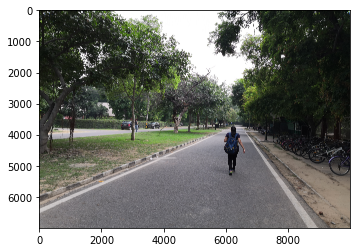

(7000, 10000, 3)

In [6]:
I = cv.imread("./val_set/8/IMG_20190930_134943.jpg", cv.IMREAD_ANYCOLOR)
I = cv.resize(I, (10000,7000))
#show_image(I)
plt.imshow(cv.cvtColor(I, cv.COLOR_BGR2RGB))
plt.show()
cv.imwrite('./abc.jpg', I)

C = np.copy(I)
C.shape

(700, 1000)


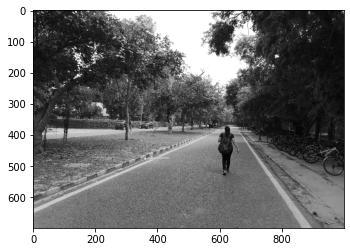

In [29]:
I = cv.imread("./val_set/8/IMG_20190930_134943.jpg", cv.IMREAD_GRAYSCALE)
I = cv.resize(I, (1000,700))
print(I.shape)
plt.imshow(I, cmap="gray")
plt.show()

In [59]:
emap = I
dim = emap.shape[:2]
graph = mf.Graph[float]()
inf = np.inf
nodes = graph.add_grid_nodes(dim)
# Source node connected to leftmost non-terminal nodes.
leftmost_nodes = nodes[:, 0]
graph.add_grid_tedges(leftmost_nodes, inf, 0)
# Sink node connected to rightmost non-terminal nodes.
rightmost_nodes = nodes[:, -1]
graph.add_grid_tedges(rightmost_nodes, 0, inf)

# Edges pointing right
structure = np.zeros((3,3))
structure[1,2] = 1
weights_fwd = np.abs(np.roll(emap, -1, axis=1) + emap)
graph.add_grid_edges(nodes, structure=structure, weights=weights_fwd, symmetric=False)

# Edges pointing down
structure = np.zeros((3,3))
structure[2,1] = 1
weights_down = np.abs(np.roll(emap, -1, axis=0) + emap)
graph.add_grid_edges(nodes, structure=structure, weights=weights_down, symmetric=True)
flow = graph.maxflow()
print('maxflow: {}'.format(flow))

maxflow: 23978.0


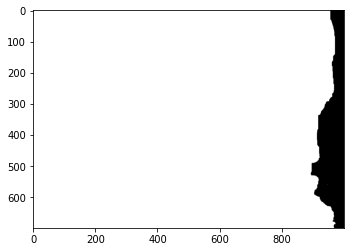

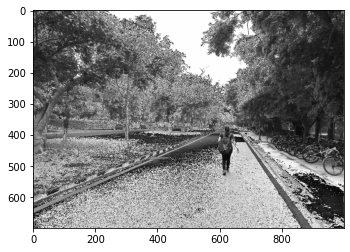

In [62]:
segments = graph.get_grid_segments(nodes)
img2 = np.int_(np.logical_not(segments))
# Show the result.
from matplotlib import pyplot as ppl
ppl.imshow(img2, cmap="gray")
ppl.show()
ppl.imshow(weights_fwd, cmap="gray")
ppl.show()

In [21]:
def plot_graph_2d(graph, nodes_shape, plot_weights=True, plot_terminals=True, font_size=7):
    X, Y = np.mgrid[:nodes_shape[0], :nodes_shape[1]]
    aux = np.array([Y.ravel(), X[::-1].ravel()]).T
    positions = {i: v for i, v in enumerate(aux)}
    positions['s'] = (-1, nodes_shape[0] / 2.0 - 0.5)
    positions['t'] = (nodes_shape[1], nodes_shape[0] / 2.0 - 0.5)

    nxgraph = graph.get_nx_graph()
    if not plot_terminals:
        nxgraph.remove_nodes_from(['s', 't'])

    plt.clf()
    nx.draw(nxgraph, pos=positions)

    if plot_weights:
        edge_labels = {}
        for u, v, d in nxgraph.edges(data=True):
            edge_labels[(u,v)] = d['weight']
        nx.draw_networkx_edge_labels(nxgraph,
                                     pos=positions,
                                     edge_labels=edge_labels,
                                     label_pos=0.3,
                                     font_size=font_size)

    plt.axis('equal')
    plt.show()